# Pipeline 

In [ ]:
%load_ext autoreload
%autoreload 2

from averitec import Datapoint
from evidence_generation import GptEvidenceGenerator, GptBatchedEvidenceGenerator, DynamicFewShotBatchedEvidenceGenerator
from classification import DefaultClassifier, HuggingfaceClassifier, AverageEnsembleClassifier, LogRegEnsembleClassifier
from retrieval import SimpleFaissRetriever, Retriever, MmrFaissRetriever, SubqueryRetriever
from pipeline import Pipeline, MockPipeline
import pickle
from labels import label2id, id2label
import numpy as np
from sklearn.metrics import classification_report
import random
from tqdm import tqdm
import htmldate
random.seed(111)

import json

## Pipeline test

In [ ]:
split = "test"
path = "/mnt/data/factcheck/averimatec/"
with open(path + f"{split}.json") as f:
    dataset = json.load(f)
    for i in range(len(dataset)):
        dataset[i]["claim_id"] = i
        dataset[i]["split"] = split
    datapoints = [Datapoint.from_dict(d) for d in dataset]

In [7]:
datapoint = Datapoint.from_dict(dataset[150])
datapoint

Datapoint(claim='A picture shows the dead body of Pakistani teenager Arsalan Naseer’s father, who, according to reports, died due to police brutality in August 2023.', claim_id=150, claim_date='2023-08-13', claim_images=['678e463de2f02e5f49857419#CLAIM#0.jpg'], speaker='@AamnaFasihi', original_claim_url='https://web.archive.org/web/20230814193338/https://twitter.com/AamnaFasihi/status/1691137083065118721', reporting_source='Twitter ', location_ISO_code='PK', label='', metadata={'transcription': '', 'media_source': '', 'modality': 'Image-text', 'image_used': 'Yes'}, justification='', split='test')

In [8]:
print(datapoint.speaker)

@AamnaFasihi


In [9]:
# retriever = SimpleFaissRetriever(path="/mnt/data/factcheck/averitec-data/data_store/vecstore/dev/6k")
retriever = MmrFaissRetriever(path=f"/mnt/data/factcheck/averimatec/vector_store/{split}/text/2k_mxbai",k=7, fetch_k=24)
# retriever = MmrFaissRetriever(path=f"/mnt/data/factcheck/averitec-data/data_store/vecstore/{split}/2k")
retrieval_result = retriever(datapoint)
retrieval_result

RetrievalResult(documents=[Document(id='87f8c597-4def-45bb-8452-a632c15b019b', metadata={'url': 'https://www.hrw.org/report/2016/09/27/crooked-system/police-abuse-and-reform-pakistan', 'context_before': 'A few days later, I was in my house preparing to go to sleep when I heard violent knocking on the door. I went out and found two local police constables outside, armed with automatic assault rifles, asking for Shahbaz. I called Shahbaz from his room. They asked him to step outside the house. In the meantime, the local SHO arrived with four more constables in his official vehicle. Upon his arrival, the constables assaulted Shahbaz, kicking and punching him. One of the constables shot him in the right shoulder with a pistol. The SHO then fired his rifle and the bullet went through his abdomen. Our neighbors tried to intervene and bring water for Shahbaz but the police fired shots in the air to scare them away. Shahbaz died on the spot in front of my eyes. There are many other witnesses t

In [10]:
retrieval_result.images

[[{'url': 'https://abcnews.go.com/US/state-suspends-brooklyn-funeral-homes-licence-stored-dozens/story?id=70451543',
   'imageUrl': 'https://s.abcnews.com/images/US/200430_wabc_funeralhomes_hpMain_4x5_992.jpg',
   'title': "State suspends Brooklyn funeral home's license after it stored dozens of bodies in rental trucks - ABC News",
   'thumbnailUrl': 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQBwlh2cc2D9Nni1Te0y1QqCglJLpveaCNk_yz1KWPSaw5cnULX',
   'content': '[breakingAppeals court disqualifies Alina Habba from serving as US attorney for New Jersey](https://abcnews.go.com/US/appeals-court-disqualifies-alina-habba-serving-us-attorney/story?id=127999613)\n\n# State suspends Brooklyn funeral home\'s license after it stored dozens of bodies in rental trucks\n\nThe state health department and Brooklyn DA seek answers.\n\nBy[Aaron Katersky](https://abcnews.go.com/author/aaron_katersky), [Mark Crudele](https://abcnews.go.com/author/mark_crudele), and [Ivan Pereira](https://abcnews

In [ ]:
# load /mnt/personal/ullriher/aic_averimatec/logs/ris_results/pretty/val.json


with open("/mnt/personal/ullriher/aic_averimatec/logs/ris_results/pretty/val.json") as f:
    ris_payload = json.load(f)
content_pool = []
for entries in ris_payload.values():
    for entry in entries.values():
        for result in entry:
            if "content" in result:
                result["content"] = result["content"][:6000]
                content_pool.append(result["content"])
            if result["page_date"]=="2000-01-01":
                result["remove"] = True
# remove all entries with remove == True and preserve structure
for entries in ris_payload.values():
    for entry in entries.values():
        entry[:] = [result for result in entry if not result.get("remove", False)]
# save back
with open("/mnt/personal/ullriher/aic_averimatec/logs/ris_results/pretty/val_clean.json", "w") as f:
    json.dump(ris_payload, f, indent=4)

#hist content lengths
lengths = [len(content.split()) for content in content_pool]
import matplotlib.pyplot as plt
plt.hist(lengths, bins=50)
plt.show()

In [11]:
from openai import OpenAI
from pathlib import Path


client = OpenAI()
IMAGE_BASE_URL = f"https://fcheck.fel.cvut.cz/images/averimatec"
user_message_content = [
    {"type": "text", "text": datapoint.claim},
]

for i, img in enumerate(datapoint.claim_images):
    user_message_content.append(
        {
            "type": "image_url",
            "image_url": {
                "url": f"{IMAGE_BASE_URL}/{img}".replace("#", "_"),
            },
        }
    )

response = client.chat.completions.create(
    model="gpt-5.1",
    messages=[
        {"role": "system", "content": "You are an expert image-text claim verifier, is this claim true?"},
        {
            "role": "user",
            "content": user_message_content
        }
    ]
)

print(response.choices[0])

Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The claim is **not supported** by the image.\n\nThe photo shows a generic scene of a body bag on a stretcher handled by people in gloves. There is nothing in the image that identifies the deceased person, the location, or the circumstances of death. Without external, verifiable evidence linking this exact photo to Arsalan Naseer’s father and to an incident of police brutality in August 2023, the claim cannot be treated as true.\n\nSo, the statement that this specific picture shows Arsalan Naseer’s father is **unverified and likely misleading**.', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))


In [12]:
user_message_content

[{'type': 'text',
  'text': 'A picture shows the dead body of Pakistani teenager Arsalan Naseer’s father, who, according to reports, died due to police brutality in August 2023.'},
 {'type': 'image_url',
  'image_url': {'url': 'https://fcheck.fel.cvut.cz/images/averimatec/678e463de2f02e5f49857419_CLAIM_0.jpg'}}]

In [13]:
datapoint.claim_images

['678e463de2f02e5f49857419#CLAIM#0.jpg']

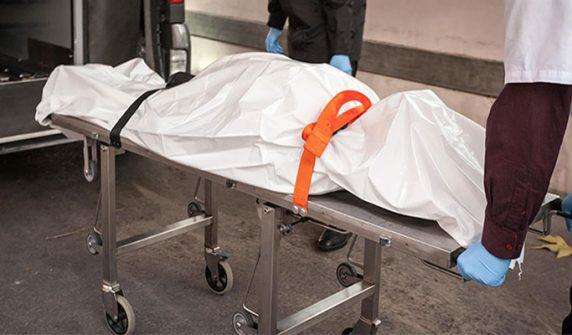

In [14]:
#display images
from IPython.display import Image, display
for img_url in datapoint.claim_images:
    display(Image("/mnt/data/factcheck/averimatec/images/"+img_url))

In [15]:
datapoint = Datapoint.from_dict(dataset[7])
datapoint.claim, datapoint.claim_date, datapoint.speaker

('Image shows an infant killed in the recent Israel Gaza Palestine war.',
 '2023-10-12',
 'Malik Asif Ali')

In [16]:
print(
    json.dumps(
        {
            "question": datapoint.claim,
            "speaker": datapoint.speaker,
            "date": datapoint.claim_date,
            "medium": datapoint.reporting_source,
        },
        indent=2,
    )
)

{
  "question": "Image shows an infant killed in the recent Israel Gaza Palestine war.",
  "speaker": "Malik Asif Ali",
  "date": "2023-10-12",
  "medium": "Facebook user post"
}


In [26]:
from classification import DefaultClassifier, HuggingfaceClassifier, AverageEnsembleClassifier, LogRegEnsembleClassifier, RandomForestClassifier, NoTiebreakClassifier

# target = path + "data_store/vecstore/test/2k"
PIPELINE_NAME = "mmr+gpt51-dfewshot-atype"
classifier = NoTiebreakClassifier()  # DefaultClassifier()
if False:
    pipeline = MockPipeline(
        dumps=f"/mnt/data/factcheck/averitec-data/data_store/submissions/{split}_mmr+gpt4o-dfewshot-tiebrk-atype.pkl",
        classifier=NoTiebreakClassifier()
    )
else:
    pipeline = Pipeline(
        #dumps = "/mnt/data/factcheck/averitec-data/data_store/submissions/dev_mmr+gpt4o-dfewshot.pkl",
        #SubqueryRetriever(retriever),
        retriever,
        evidence_generator=DynamicFewShotBatchedEvidenceGenerator(), 
        classifier=classifier
    )

In [27]:
list(enumerate(retrieval_result.images))

[(0,
  [{'url': 'https://abcnews.go.com/US/state-suspends-brooklyn-funeral-homes-licence-stored-dozens/story?id=70451543',
    'imageUrl': 'https://s.abcnews.com/images/US/200430_wabc_funeralhomes_hpMain_4x5_992.jpg',
    'title': "State suspends Brooklyn funeral home's license after it stored dozens of bodies in rental trucks - ABC News",
    'thumbnailUrl': 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQBwlh2cc2D9Nni1Te0y1QqCglJLpveaCNk_yz1KWPSaw5cnULX',
    'content': '[breakingAppeals court disqualifies Alina Habba from serving as US attorney for New Jersey](https://abcnews.go.com/US/appeals-court-disqualifies-alina-habba-serving-us-attorney/story?id=127999613)\n\n# State suspends Brooklyn funeral home\'s license after it stored dozens of bodies in rental trucks\n\nThe state health department and Brooklyn DA seek answers.\n\nBy[Aaron Katersky](https://abcnews.go.com/author/aaron_katersky), [Mark Crudele](https://abcnews.go.com/author/mark_crudele), and [Ivan Pereira](https

In [28]:
PIPELINE_NAME = "base64"

In [21]:
split

'test'

In [29]:
submission = []
dump = []

for dp in tqdm(datapoints):
    pipeline_result = pipeline(dp)
    submission.append(pipeline_result.to_submission())
    dump.append(pipeline_result)
with open(f"{path}submissions/{split}_{PIPELINE_NAME}.json", "w") as f:
    json.dump(submission, f, indent=4)
with open(f"{path}submissions/{split}_{PIPELINE_NAME}.pkl", "wb") as f:
    pickle.dump(dump, f)

100%|██████████| 352/352 [02:57<00:00,  1.98it/s]


In [30]:
files = pipeline.evidence_generator.get_batch_files(path=f"/mnt/data/factcheck/averimatec/batch_jobs/{split}_{PIPELINE_NAME}", batch_size=352)

In [31]:
files

['/mnt/data/factcheck/averimatec/batch_jobs/test_base64/batch_1.jsonl']

In [ ]:
batch_results = pipeline.evidence_generator.submit_and_await_batches(
    files, f"/mnt/data/factcheck/averimatec/batch_jobs/{split}_{PIPELINE_NAME}/output.jsonl"
)

  0%|          | 0/1 [00:00<?, ?it/s]

Batch(id='batch_692ff767474081909515b3be2b2e7b94', completion_window='24h', created_at=1764751207, endpoint='/v1/chat/completions', input_file_id='file-FPTjUnM8rJTvK9SNf6Dssx', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1764837607, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'dev-set job, batch 1'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0), model=None, usage={'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0, 'input_tokens_details': {'cached_tokens': 0}, 'output_tokens_details': {'reasoning_tokens': 0}})
waiting for batch to complete BatchRequestCounts(completed=0, failed=0, total=0) batch_692ff767474081909515b3be2b2e7b94
waiting for batch to complete BatchRequestCounts(completed=0, failed=0, total=352) batch_692ff767474081909515b3be2b2e7b94
waiting for batch to complete BatchRequestCo

In [ ]:
with open(f"/mnt/data/factcheck/averimatec/batch_jobs/{split}_{PIPELINE_NAME}2/output.jsonl") as f:
    batch_results = [json.loads(line)["response"]["body"]["choices"][0]["message"]["content"] for line in f]

In [ ]:
new_result = pipeline.evidence_generator.update_pipeline_result(pipeline_result, batch_results, pipeline.classifier)

In [ ]:
new_dump = []
pipeline.evidence_generator.fallback_gpt_generator.client.temperature = 0.5
for pipeline_result, batch_result in zip(dump[: len(batch_results)], batch_results):

    new_result = pipeline.evidence_generator.update_pipeline_result(
        pipeline_result, batch_result, pipeline.classifier
    )
    new_dump.append(new_result)

In [ ]:
new_result.to_submission()

In [ ]:
new_dump = []
pipeline.evidence_generator.fallback_gpt_generator.client.temperature = .5
for pipeline_result, batch_result in zip(dump[:len(batch_results)], batch_results):
    new_result = pipeline.evidence_generator.update_pipeline_result(pipeline_result, batch_result, pipeline.classifier)
    new_dump.append(new_result)


In [ ]:
with open(f"{path}submissions/{split}_{PIPELINE_NAME}.json", "w") as f:
    json.dump([d.to_submission() for d in new_dump], f, indent=4)
with open(f"{path}submissions/{split}_{PIPELINE_NAME}.pkl", "wb") as f:
    pickle.dump(new_dump, f)

In [ ]:
(
    new_dump[1],
    new_dump[1].evidence_generation_result,
    new_dump[1].classification_result
)

In [ ]:
with open(f"/mnt/data/factcheck/averitec-data/data_store/submissions/{split}_{PIPELINE_NAME}.json", "w") as f:
    json.dump([d.to_submission() for d in new_dump], f, indent=4)
with open(f"/mnt/data/factcheck/averitec-data/data_store/submissions/{split}_{PIPELINE_NAME}.pkl", "wb") as f:
    pickle.dump(new_dump, f)

In [ ]:
with open(f"/mnt/data/factcheck/averitec-data/data_store/submissions/{split}_{PIPELINE_NAME}.json", "w") as f:
    json.dump([d.to_submission() for d in new_dump], f, indent=4)
with open(f"/mnt/data/factcheck/averitec-data/data_store/submissions/{split}_{PIPELINE_NAME}.pkl", "wb") as f:
    pickle.dump(new_dump, f)

## collapsible begin

In [ ]:
from IPython.display import display, Markdown, Latex

In [ ]:
knn_retrieval_result = retriever(datapoint)
display(Markdown("### 🗯️ " + datapoint.claim))
display(Markdown("*Retrieved by knn*\n\n"))
# sample 3
for r in knn_retrieval_result:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content[:256]}"))

In [ ]:
from retrieval import MmrFaissRetriever

mmr_retriever = MmrFaissRetriever(retriever.path)
mmr_retrieval_result = mmr_retriever(datapoint)
display(Markdown("### 🗯️ " + datapoint.claim))
display(Markdown("*Retrieved by MMR*\n\n"))
# sample 3
for r in mmr_retrieval_result:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content[:256]}"))

In [ ]:
subquery_retriever = SubqueryRetriever(retriever)
subquery_retrieval_result = subquery_retriever(datapoint)
display(Markdown("### 🗯️ " + datapoint.claim))
display(Markdown("*Retrieved by subqueries*\n\n"))
# sample 3
for r in subquery_retrieval_result:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n*{';'.join(r.metadata['queries'])}*\n\n{r.page_content[:256]}"))

In [ ]:
subquery_retrieval_result.metadata

## Collapsible section end

In [ ]:
evidence_generator = GptBatchedEvidenceGenerator("gpt-4o")
evidence_generation_result = evidence_generator(datapoint, retrieval_result)
evidence_generation_result

In [ ]:
evidence_generation_result.metadata["suggested_label"]

In [ ]:
datapoint.label

In [ ]:
classifier = DefaultClassifier()
classification_result = classifier(datapoint, evidence_generation_result, retrieval_result)
str(classification_result), classification_result

In [ ]:
datapoint2 = Datapoint.from_dict(dataset[16])
pipeline = Pipeline(retriever, evidence_generator, classifier)
pipeline_result = pipeline(datapoint2)
pipeline_result

In [ ]:
str(pipeline_result.classification_result), datapoint2.label

In [ ]:
pipeline_result.to_submission()

In [ ]:
# pickle dump pipeline result
import pickle
with open('data/pipeline_result.pkl', 'wb') as f:
    pickle.dump(pipeline_result, f)

In [ ]:
%run src/prediction/evaluate_veracity.py --label_file /mnt/data/factcheck/averitec-data/data/dev.json --prediction_file /mnt/data/factcheck/averitec-data/data_store/submission_dev_avg_clf.json

In [ ]:
import json, os
# crawl /mnt/data/factcheck/averitec-data/data_store/batch_jobs and each time you find gpt4o in folder name and "output" in filename, load the file and add its line count to line_counts
line_counts = []
for root, dirs, files in os.walk("/mnt/data/factcheck/averitec-data/data_store/batch_jobs"):
    #print(root, files)
    if "gpt4o" in root:
        for f in files:
            if "output" in f:
                print(os.path.join(root,f))
                with open(os.path.join(root,f)) as f:
                    line_counts.append(len(f.readlines()))
            

In [ ]:
line_counts

In [ ]:
()/sum(line_counts)